<a href="https://colab.research.google.com/github/mariabandeira/Projeto_Final_IIA/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [80]:
!pip install  seaborn

Defaulting to user installation because normal site-packages is not writeable


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from tqdm.notebook import tqdm
from collections import Counter

In [82]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('punkt')  

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [83]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [84]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

## Sentiment Analysis

In [85]:
# neg_df = pd.read_csv('/content/NEGATIVE_B006K2ZZ7K.csv', sep=';')
neg_df = pd.read_csv('datasets/NEGATIVE_B006K2ZZ7K.csv', sep=';')
# pos_df = pd.read_csv('/content/POSITIVE_B006K2ZZ7K.csv', sep=';')
pos_df = pd.read_csv('datasets/POSITIVE_B006K2ZZ7K.csv', sep=';')

In [86]:
neg_df.head()

,username,title,model,verified,date,region,text,stars,id
0,Cyn,Would not recommend,0,Verified Purchase,"July 24, 2013",United States,\r\nThe taffy arrived in one big lump. The wax...,1.0,B006K2ZZ7K
1,Machelle,Could be better,0,Verified Purchase,"June 16, 2016",United States,\r\nSoft taffy in a large variety of flavors. ...,3.0,B006K2ZZ7K
2,Lewis,Good taffy but sticks to wrapper,0,Verified Purchase,"April 17, 2013",United States,\r\nThe taffy was received on time and in good...,2.0,B006K2ZZ7K
3,TERA ENDRES,Don’t buy!!!,0,Verified Purchase,"November 6, 2018",United States,\r\nI opened the box and the salt water taffy ...,1.0,B006K2ZZ7K
4,Claire M,I did enjoy some of the flavors so they get tw...,0,Verified Purchase,"June 21, 2017",United States,\r\nLots of the candy arrived poorly wrapped a...,2.0,B006K2ZZ7K


In [87]:
pos_df.head()

,username,title,model,verified,date,region,text,stars,id
0,mbb0623,This salt Water Taffy assortment is the absolu...,0,Verified Purchase,"September 13, 2015",United States,\r\nThis salt Water Taffy assortment is the ab...,5.0,B006K2ZZ7K
1,Mrs. V. M. Bruss,Good taffy. Will last s a while,0,Verified Purchase,"May 29, 2013",United States,\r\nI bought this for my son's graduation part...,4.0,B006K2ZZ7K
2,dmb,"Buy it, you'll like it.",0,Verified Purchase,"November 23, 2013",United States,"\r\nSo many flavors, some I've never had. I w...",5.0,B006K2ZZ7K
3,David C. Sullivan,Great! Just as good as the expensive brands!,0,Verified Purchase,"June 20, 2012",United States,\r\nThis saltwater taffy had great flavors and...,5.0,B006K2ZZ7K
4,Amazon Customer,A different taffy!,0,Verified Purchase,"April 28, 2021",United States,\r\nThe flavors are definitely different they'...,4.0,B006K2ZZ7K


In [88]:
df = (pd.concat([neg_df, pos_df], ignore_index=True)
     .assign(origem=lambda x: ['negative'] * len(neg_df) + ['positive'] * len(pos_df)))

In [89]:
df.head()

,username,title,model,verified,date,region,text,stars,id,origem
0,Cyn,Would not recommend,0,Verified Purchase,"July 24, 2013",United States,\r\nThe taffy arrived in one big lump. The wax...,1.0,B006K2ZZ7K,negative
1,Machelle,Could be better,0,Verified Purchase,"June 16, 2016",United States,\r\nSoft taffy in a large variety of flavors. ...,3.0,B006K2ZZ7K,negative
2,Lewis,Good taffy but sticks to wrapper,0,Verified Purchase,"April 17, 2013",United States,\r\nThe taffy was received on time and in good...,2.0,B006K2ZZ7K,negative
3,TERA ENDRES,Don’t buy!!!,0,Verified Purchase,"November 6, 2018",United States,\r\nI opened the box and the salt water taffy ...,1.0,B006K2ZZ7K,negative
4,Claire M,I did enjoy some of the flavors so they get tw...,0,Verified Purchase,"June 21, 2017",United States,\r\nLots of the candy arrived poorly wrapped a...,2.0,B006K2ZZ7K,negative


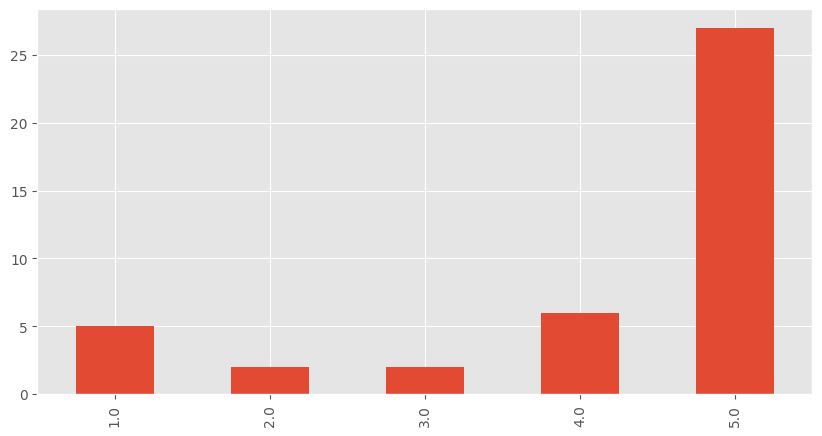

In [90]:
ax = df['stars'].value_counts().sort_index().plot(kind='bar', title='', figsize=(10,5))
ax.set_xlabel('')
plt.show()

### Basic NLTK

In [91]:
example = df['text'][7]
print(example)


Just awful....



In [92]:
tokens = nltk.word_tokenize(example)

In [93]:
#token pos
tagged = nltk.pos_tag(tokens)

In [94]:
nltk.download('maxent_ne_chunker') 
nltk.download('averaged_perceptron_tagger')  

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [95]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [96]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() #pretty print

(S Just/RB awful/JJ ..../NNS)


### Pretrained Model

In [97]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\biabc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [98]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt') # output should be pytorch tensors(vectors)
  output = model(**encoded_text) # passing the enconded(tokenized) text into RoBERTa
  scores = output[0][0].detach().numpy()
  scores = softmax(scores) #converts the scores into probabilities
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }

  return scores_dict

In [99]:
df = df.rename(columns={'id': 'product_id'})

In [100]:
df['Id'] = df.index

In [101]:
df = df.dropna()

In [102]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [103]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [104]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['text']
    myid = row['Id']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/37 [00:00<?, ?it/s]

In [105]:
results_df = pd.DataFrame(res).T

In [106]:
results_df

,roberta_neg,roberta_neu,roberta_pos
0,0.934816,0.057157,0.008027
1,0.916286,0.076291,0.007423
2,0.088879,0.290511,0.620609
3,0.877001,0.112434,0.010565
4,0.137900,0.252092,0.610008
5,0.864869,0.122268,0.012863
6,0.633289,0.321335,0.045376
7,0.938871,0.053954,0.007176
9,0.002706,0.008852,0.988442
10,0.075734,0.184677,0.739589


In [107]:
#results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [108]:
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,username,title,model,verified,date,region,text,stars,product_id,origem
0,0,0.934816,0.057157,0.008027,Cyn,Would not recommend,0,Verified Purchase,"July 24, 2013",United States,\r\nThe taffy arrived in one big lump. The wax...,1.0,B006K2ZZ7K,negative
1,1,0.916286,0.076291,0.007423,Machelle,Could be better,0,Verified Purchase,"June 16, 2016",United States,\r\nSoft taffy in a large variety of flavors. ...,3.0,B006K2ZZ7K,negative
2,2,0.088879,0.290511,0.620609,Lewis,Good taffy but sticks to wrapper,0,Verified Purchase,"April 17, 2013",United States,\r\nThe taffy was received on time and in good...,2.0,B006K2ZZ7K,negative
3,3,0.877001,0.112434,0.010565,TERA ENDRES,Don’t buy!!!,0,Verified Purchase,"November 6, 2018",United States,\r\nI opened the box and the salt water taffy ...,1.0,B006K2ZZ7K,negative
4,4,0.137900,0.252092,0.610008,Claire M,I did enjoy some of the flavors so they get tw...,0,Verified Purchase,"June 21, 2017",United States,\r\nLots of the candy arrived poorly wrapped a...,2.0,B006K2ZZ7K,negative
5,5,0.864869,0.122268,0.012863,Amanda,"Large bag, not great",0,Verified Purchase,"August 15, 2017",United States,"\r\nLarge bag, however the taffy is not very g...",3.0,B006K2ZZ7K,negative
6,6,0.633289,0.321335,0.045376,-A.,Hard as a rock!,0,Verified Purchase,"January 4, 2015",United States,"\r\nHard as a rock. Tried the ""soften it in th...",1.0,B006K2ZZ7K,negative
7,7,0.938871,0.053954,0.007176,Nagatha,One Star,0,Verified Purchase,"December 26, 2016",United States,\r\nJust awful....\r\n,1.0,B006K2ZZ7K,negative
8,9,0.002706,0.008852,0.988442,mbb0623,This salt Water Taffy assortment is the absolu...,0,Verified Purchase,"September 13, 2015",United States,\r\nThis salt Water Taffy assortment is the ab...,5.0,B006K2ZZ7K,positive
9,10,0.075734,0.184677,0.739589,Mrs. V. M. Bruss,Good taffy. Will last s a while,0,Verified Purchase,"May 29, 2013",United States,\r\nI bought this for my son's graduation part...,4.0,B006K2ZZ7K,positive


In [109]:
results_df['roberta_pos'].sum()

25.980482

In [110]:
results_df['roberta_neu'].sum()

4.4824033

In [111]:
results_df['roberta_neg'].sum()

6.5371156

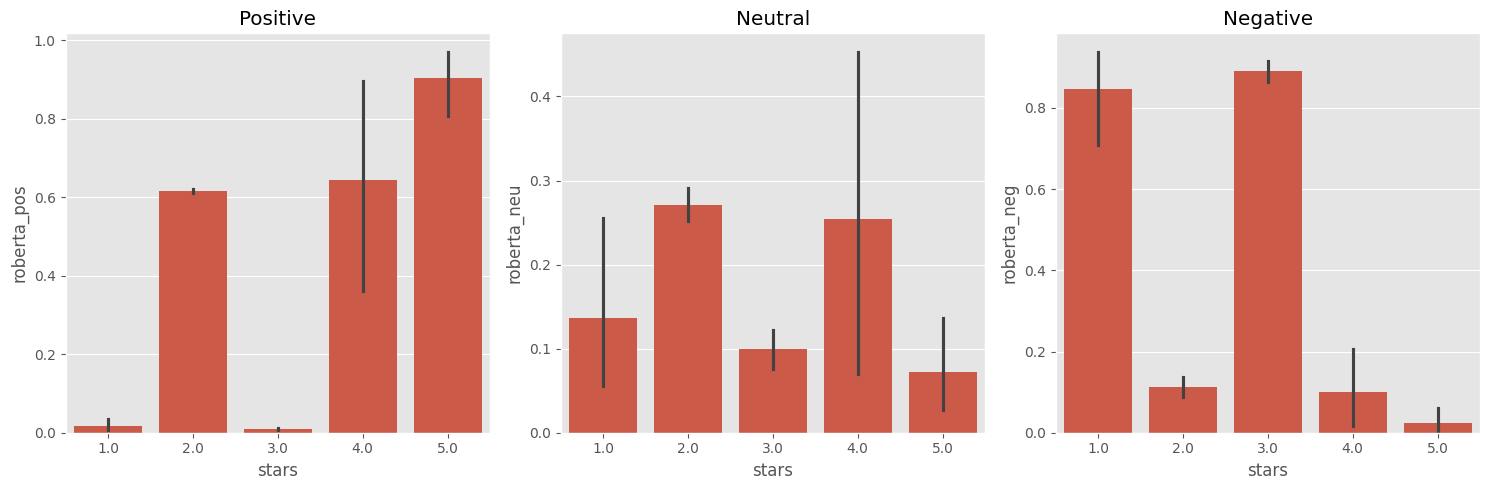

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=results_df, x='stars', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='stars', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='stars', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [113]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable


In [114]:
from textblob import Word, TextBlob


In [115]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [117]:
import spacy
spacy.cli.download("en_core_web_sm") 


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [118]:
import string
import spacy.cli

positive_text = []
negative_text = []

for index, row in results_df.iterrows():
    if row['roberta_neg'] > row['roberta_pos']:
        negative_text.append(row['text'])
    else:
        positive_text.append(row['text'])

positive_text = ' '.join(positive_text)

negative_text = ' '.join(negative_text)


positive_text = positive_text.lower()
negative_text = negative_text.lower()

nlp = spacy.load('en_core_web_sm')
doc_p = nlp(positive_text) #positive doc
doc_n = nlp(negative_text) #negative doc

# adding adjectives only restriction
p_notadjectives = [token.text for token in doc_p if token.pos_ != "ADJ"]
n_notadjectives = [token.text for token in doc_n if token.pos_ != "ADJ"]
p_adjectives = [token.text for token in doc_p if token.pos_ == "ADJ"]
n_adjectives = [token.text for token in doc_n if token.pos_ == "ADJ"]

stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords and word in p_adjectives]
neg_tokens = [word for word in neg_tokens if word not in stopwords and word in n_adjectives]

clean_pos_tokens = []
clean_neg_tokens = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [119]:
pos_tokens_nofilter = [word for word in pos_tokens if word not in stopwords ]
neg_tokens_nofilter = [word for word in neg_tokens if word not in stopwords]

clean_pos_tokens_nf = []
clean_neg_tokens_nf = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens_nf.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens_nf.append(clean_token)

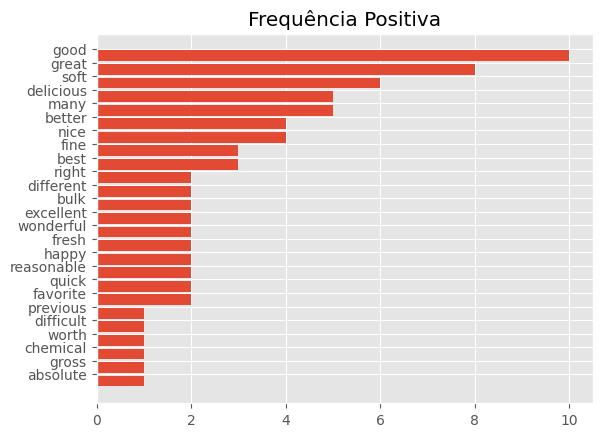

In [120]:
pos_freq = dict(Counter(clean_pos_tokens))
#pos_freq.pop('q')
#pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

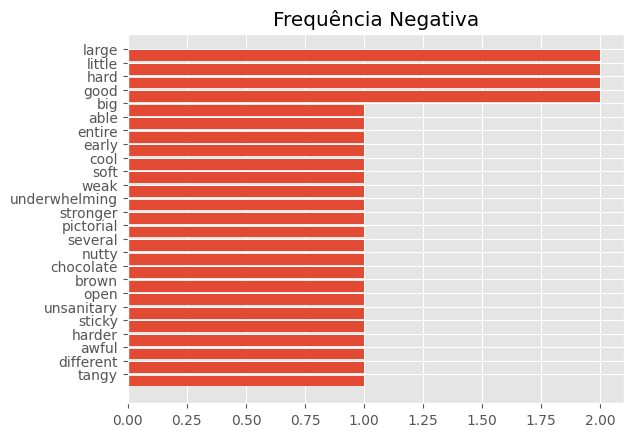

In [121]:
neg_freq = dict(Counter(clean_neg_tokens))
#neg_freq.pop('q')
pos_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

plt.barh(range(25), [neg_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Negativa')
plt.show()

In [122]:
def filter_words_by_pos(words_list, pos_class):
    tagged_words = pos_tag(word_tokenize(' '.join(words_list)))
    filtered_words = [word for word, pos in tagged_words if pos == pos_class]
    return filtered_words

# Exemplo de uso da função
pos_class = 'NN'  # Substantivos (nouns)
filtered_pos_nouns = filter_words_by_pos(clean_pos_tokens, pos_class)
filtered_neg_nouns = filter_words_by_pos(clean_neg_tokens, pos_class)
print(filtered_pos_nouns)
print(filtered_neg_nouns)

['fine', 'chemical', 'absolute', 'sweet', 'tasty', 'honest', 'bulk', 'rubbery', 'bulk', 'fair', 'wild', 'delightful', 'excellent', 'wonderful', 'happier', 'yummy', 'excellent', 'good', 'favorite']
['cool', 'underwhelming', 'chocolate', 'harder', 'tangy', 'good']


In [123]:
def filter_words_by_pos(words_list, pos_class):
    tagged_words = pos_tag(words_list)
    filtered_words = [word for word, pos in tagged_words if pos == pos_class]
    return filtered_words

# Exemplo de uso da função
pos_classes = ('JJ', 'JJR', 'JJS')  # Adjetivos
filtered_pos_nouns = filter_words_by_pos(clean_pos_tokens_nf, pos_class)
filtered_neg_nouns = filter_words_by_pos(clean_neg_tokens_nf, pos_class)
print(filtered_pos_nouns)
print(filtered_neg_nouns)

['fine', 'chemical', 'absolute', 'sweet', 'tasty', 'honest', 'bulk', 'rubbery', 'bulk', 'fair', 'wild', 'delightful', 'excellent', 'wonderful', 'happier', 'yummy', 'excellent', 'good', 'favorite']
['cool', 'underwhelming', 'chocolate', 'harder', 'tangy', 'good']


In [ ]:
# pos_freq = dict(Counter(filtered_pos_nouns))
# #pos_freq.pop('q')
# #pos_freq.pop('pra')
# pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

# plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
# plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
# plt.title('Frequência Positiva')
# plt.show()

In [ ]:
# neg_freq = dict(Counter(filtered_neg_nouns))
# #neg_freq.pop('q')
# #neg_freq.pop('pra')
# neg_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

# plt.barh(range(14), [neg_freq[w] for w in reversed(neg_popular_words[0:14])])
# plt.yticks([x + 0.5 for x in range(14)], reversed(neg_popular_words[0:14]))
# plt.title('Frequência Negativa')
# plt.show()

### Combine and Compare

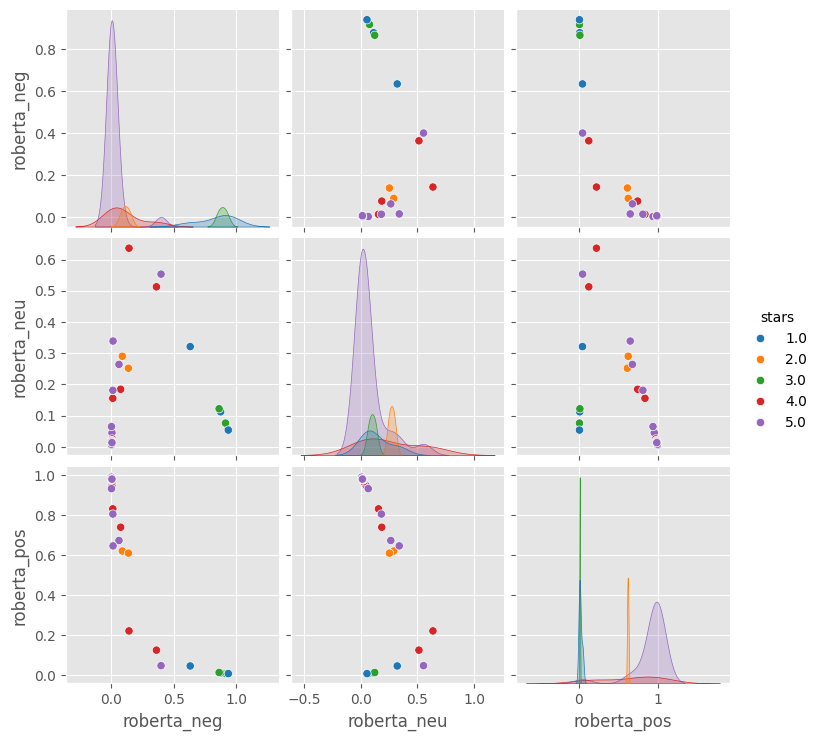

In [124]:
sns.pairplot(data=results_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='stars',
            palette='tab10')
plt.show()

In [ ]:
results_df.query('stars == 1') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

'\r\nHard as a rock. Tried the "soften it in the mouth trick"- too sticky.  Tried the microwave thing, too gooey and then even harder.  Had to pitch.\r\n'

In [ ]:
results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

'\r\ntasty, used for wedding favors\r\n'

## Extra: the transformers pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\biabc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\biabc\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

#### Testing the model prediction

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

## Using Textblob

In [ ]:
!pip install -U textblob

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install deep-translator

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   ----------------------------- ---------- 30.7/42.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 42.3/42.3 kB 516.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/147.9 kB ? eta -:--:--
   ------------------- -------------------- 71.7/147.9 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 147.9/147.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
from textblob import TextBlob
from deep_translator import GoogleTranslator
import pandas as pd

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import string
from textblob import TextBlob, Word
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\biabc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Testing deep_translator for translating port -->> eng

In [ ]:
tradutor = GoogleTranslator(source= "pt", target= "en")

In [ ]:
text = "Eu ODEIO essa música! Mas a letra é muito boa"
traducao = tradutor.translate(text)
blob = TextBlob(traducao)

In [ ]:
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(polarity)
print(subjectivity)
print(blob.sentiment)

-0.04500000000000004
0.8400000000000001
Sentiment(polarity=-0.04500000000000004, subjectivity=0.8400000000000001)


In [ ]:
df_eng_n = pd.read_csv('datasets/NEGATIVE_B0BVB5PTDK.csv', sep=';')
df_eng_p = pd.read_csv('datasets/POSITIVE_B0BVB5PTDK.csv', sep=';')

df_eng = df_eng_n + df_eng_p

In [ ]:
df_eng

NameError: name 'df_eng' is not defined

In [ ]:
df_eng['text'] = df_eng['text'].apply(lambda x: tradutor.translate(x) if len(x) < 5000 else x)

NameError: name 'df_eng' is not defined

In [ ]:
df = df.dropna()

In [ ]:
def sentences_tokenization(text):
  sentences = []
  blob = TextBlob(text)
  for sentence in blob.sentences:
    sentences.append(str(sentence))

  return sentences

In [ ]:
df['sentences'] = df['text'].apply(sentences_tokenization)

In [ ]:
df['sentences_en'] = df['reviews_en'].apply(sentences_tokenization)

KeyError: 'reviews_en'

In [ ]:
def sentiment_analysis(sentences):
  sentiments = []
  for sentence in sentences:
    blob = TextBlob(sentence)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

  return sentiments

In [ ]:
df['sentences_sentiments'] = df['sentences'].apply(sentiment_analysis)

<ipython-input-38-41df6f1781b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences_sentiments'] = df['sentences'].apply(sentiment_analysis)


In [ ]:
df['positive_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento > 0], axis=1)

<ipython-input-39-c40ce6280389>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positive_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento > 0], axis=1)


In [ ]:
df['negative_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento < 0], axis=1)

<ipython-input-40-30b266d9537c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative_sentences'] = df.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento < 0], axis=1)


In [ ]:
df

,username,title,date,region,text,stars,sentences,sentences_sentiments,positive_sentences,negative_sentences
0,Ls,what r u waiting for?!?!?!?!?!?!?!?!?,"December 23, 2023",United States,I’m in love!!!! Not so much with the price but...,5,"[I’m in love!!!!, Not so much with the price b...","[1.0, 0.1, -0.15, -0.09999999999999999, 0.0, 0...","[I’m in love!!!!, Not so much with the price b...",[I was hesitant to purchase a $1600 vacuum/ mo...
1,Jenniferc9695,Perfection Has Arrived,"April 14, 2024",United States,I love my old Roborock. Actually it's not even...,5,"[I love my old Roborock., Actually it's not ev...","[0.3, 0.14444444444444446, -0.2333333333333333...","[I love my old Roborock., Actually it's not ev...","[But with this S8 Pro Ultra, they have fixed a..."
3,Dave,"Awesome vacuum, offensive customer support","September 8, 2023",United States,The vacuum does a great job when it is working...,1,[The vacuum does a great job when it is workin...,"[0.39583333333333337, 0.0, -0.3, 0.0, 0.0, 0.2...",[The vacuum does a great job when it is workin...,"[Their customer support sucks., The other revi..."
5,J. Dyer,Clean floors and hyper accurate mapping,"February 9, 2024",United States,"I’ve had many robot vacuums, high-end iRobot a...",4,"[I’ve had many robot vacuums, high-end iRobot ...","[0.4, 0.5833333333333334, 0.020606060606060607...","[I’ve had many robot vacuums, high-end iRobot ...",[Since it cleans the mop head it’s not just pu...
6,L. H.,Worth the $,"April 22, 2024",United States,I moved my other brand robot floor cleaner to ...,5,[I moved my other brand robot floor cleaner to...,"[-0.10833333333333334, 1.0, 0.3333333333333333...","[This one is impressive., I schedule my main r...",[I moved my other brand robot floor cleaner to...
...,...,...,...,...,...,...,...,...,...,...
92,Julia Z,I: We Love This Machine,"April 20, 2024",United States,"The Best thing ever. Sweeps, mops, cleans itse...",5,"[The Best thing ever., Sweeps, mops, cleans it...","[1.0, 0.0, 0.0, 0.75, 0.0, 0.41666666666666663]","[The Best thing ever., The S5 takes care of th...",[]
94,Chris,So much better than iRobot,"February 7, 2024",United States,So long term iRobot user most recently with a ...,5,[So long term iRobot user most recently with a...,"[0.15, 0.1322222222222222, 0.3681818181818182,...",[So long term iRobot user most recently with a...,[]
95,Christopher J.,Much better than iRobot S6,"January 1, 2024",United States,Robots seems to know where it is much more tha...,4,[Robots seems to know where it is much more th...,"[0.16666666666666669, 0.13636363636363635, 0.4...",[Robots seems to know where it is much more th...,[]
97,SHIPS FROM NYC,App was not working,"January 27, 2024",United States,Had to send it back to factory. So far working...,4,"[Had to send it back to factory., So far worki...","[0.0, 0.3]",[So far working ok. Extended warranty recommen...,[]


In [ ]:
positive_text = [str(frase) for frase in df['positive_sentences']]
positive_text = ' '.join(positive_text)

negative_text = [str(frase) for frase in df['negative_sentences']]
negative_text = ' '.join(negative_text)

stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

positive_text = positive_text.lower()
negative_text = negative_text.lower()

wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords]
neg_tokens = [word for word in neg_tokens if word not in stopwords]

clean_pos_tokens = []
clean_neg_tokens = []

for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [ ]:
print(clean_pos_tokens)

['’', 'love', 'not', 'much', 'price', 'extra', 'time', 'say', 'tempted', 'never', 'believed', 'would', 'actually', 'good', 'job', 'this', 'product', 'amazing', '’', 'able', 'find', 'list', 'errors', 'instruction', 'manual', 'started', 'get', 'really', 'upset', 'finally', 'able', 'find', '1', 'person', 'got', 'response', 'roborock', 'the', 'whole', 'process', 'took', '14', 'minutes', 'some', 'people', 'said', 'vacuums', 'certain', 'days', 'mops', 'others', '’', 'figured', 'set', 'different', 'schedules', 'vacuum', 'mop', 'sunday', 'wednesday', 'friday', 'every', 'often', 'u', 'flip', 'robot', 'clean', 'hair', 'buildup', 'well', 'wipe', 'dock', 'my', 'boyfriend', 'wants', 'project', 'every', '2', 'weeks', 'stays', 'shinny', 'new', 'the', 'directions', 'show', 'picture', 'faucet', 'dropping', 'tap', 'water', 'clean', 'water', 'tank', 'live', 'florida', 'super', 'hard', 'water', 'my', 'boyfriend', '’', 'believe', 'clean', 'floor', 'house', 'it', 'costs', '19', 'bottle', 'u', 'use', 'cap', 

In [ ]:
print(clean_neg_tokens)

['hesitant', 'purchase', '1600', 'vacuum', 'mop', 'reading', 'least', '50', 'reviews', 'multiple', 'websites…', 'convinced', 'it', 'took', 'lot', 'longer', 'arrive', 'bc', 'shipped', 'directly', 'roborock', 'arkansas', 'via', 'ups', '’', 'surprised', 'amazon', 'gets', 'delivery', 'date', 'wrong', 'at', 'least', 'point', '’', 'feel', 'like', 'wasted', 'fortune', 'something', 'broken', 'arrived', 'closed', 'door', 'back', 'bedroom', 'bc', '’', 'room', 'everything', 'goes', 'die', 'nowhere', 'even', 'turn', 'around', 'room', 'notice', 'trouble', 'distinguishing', 'btwn', 'inside', 'outside', 'comes', 'contact', 'sliding', 'glass', 'doors', 'shades', 'it', 'tells', 'u', 'long', '’', 'running', 'battery', 'life', 'some', 'people', 'said', 'dirty', 'water', 'tank', 'smell', 'time', 'return', 'home', 'night', 'dump', 'outside', 'rinse', 'sink', 'thought', 'would', 'vacuum', 'entire', 'house', '1st', 'gonback', 'mop', '’', 'works', '2', 'small', 'microfiber', 'mats', 'house', 'she', 'make', 'l

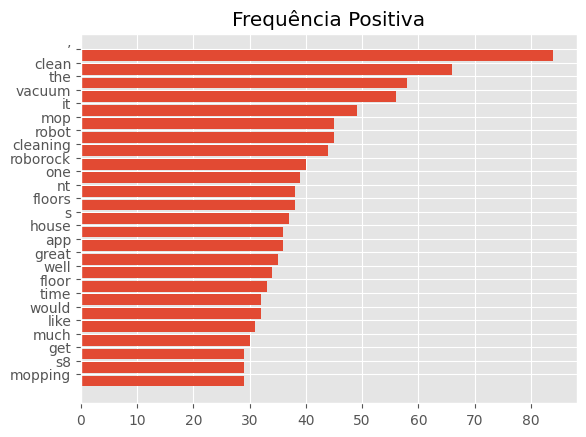

In [ ]:
from collections import Counter

pos_freq = dict(Counter(clean_pos_tokens))
#pos_freq.pop('q')
#pos_freq.pop('pra')
pos_popular_words = sorted(pos_freq, key = pos_freq.get, reverse = True)

plt.barh(range(25), [pos_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Positiva')
plt.show()

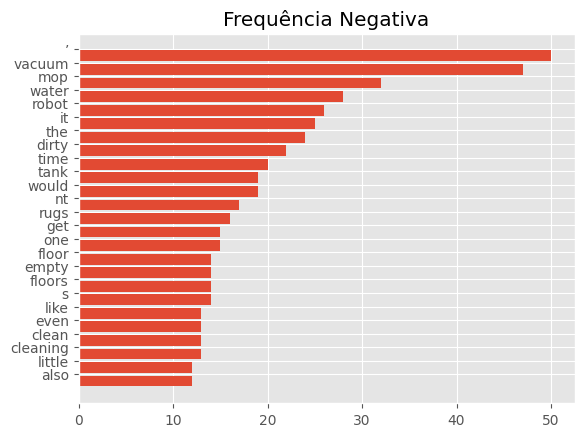

In [ ]:
neg_freq = dict(Counter(clean_neg_tokens))
#neg_freq.pop('q')
pos_popular_words = sorted(neg_freq, key = neg_freq.get, reverse = True)

plt.barh(range(25), [neg_freq[w] for w in reversed(pos_popular_words[0:25])])
plt.yticks([x + 0.5 for x in range(25)], reversed(pos_popular_words[0:25]))
plt.title('Frequência Negativa')
plt.show()

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.tag.pos_tag(clean_neg_tokens)

## NRC Lexicon

In [ ]:
!pip install NRCLex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=27cc77c7e11f7fa6b595402b39ba5da31468798e9f07d4453674e4f164a06f22
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex


In [ ]:
# Import required modules
from nrclex import NRCLex
from collections import Counter

In [ ]:
df

,username,title,model,verified,date,region,text,stars,product_id,origem,Id
0,Cyn,Would not recommend,0,Verified Purchase,"July 24, 2013",United States,\nThe taffy arrived in one big lump. The wax w...,1.0,B006K2ZZ7K,negative,0
1,Machelle,Could be better,0,Verified Purchase,"June 16, 2016",United States,\nSoft taffy in a large variety of flavors. Ho...,3.0,B006K2ZZ7K,negative,1
2,Lewis,Good taffy but sticks to wrapper,0,Verified Purchase,"April 17, 2013",United States,\nThe taffy was received on time and in good c...,2.0,B006K2ZZ7K,negative,2
3,TERA ENDRES,Don’t buy!!!,0,Verified Purchase,"November 6, 2018",United States,\nI opened the box and the salt water taffy ba...,1.0,B006K2ZZ7K,negative,3
4,Claire M,I did enjoy some of the flavors so they get tw...,0,Verified Purchase,"June 21, 2017",United States,\nLots of the candy arrived poorly wrapped and...,2.0,B006K2ZZ7K,negative,4
5,Amanda,"Large bag, not great",0,Verified Purchase,"August 15, 2017",United States,"\nLarge bag, however the taffy is not very goo...",3.0,B006K2ZZ7K,negative,5
6,-A.,Hard as a rock!,0,Verified Purchase,"January 4, 2015",United States,"\nHard as a rock. Tried the ""soften it in the ...",1.0,B006K2ZZ7K,negative,6
7,Nagatha,One Star,0,Verified Purchase,"December 26, 2016",United States,\nJust awful....\n,1.0,B006K2ZZ7K,negative,7
9,mbb0623,This salt Water Taffy assortment is the absolu...,0,Verified Purchase,"September 13, 2015",United States,\nThis salt Water Taffy assortment is the abso...,5.0,B006K2ZZ7K,positive,9
10,Mrs. V. M. Bruss,Good taffy. Will last s a while,0,Verified Purchase,"May 29, 2013",United States,\nI bought this for my son's graduation party ...,4.0,B006K2ZZ7K,positive,10


In [ ]:
df = df.dropna()

In [ ]:
texts = [text for text in df['text']] # putting reviews in a list

emotions = []

for text in texts:  # Here we give the song the average emotion in it

    e = NRCLex(text)
    if e.affect_list:  # Verifica se a lista não está vazia
        mode = max(e.affect_list, key=Counter(e.affect_list).get)
        emotions.append(mode)
    else:
        ind = df.loc[df['text'] == text].index
        df = df.drop(ind) # remove songs wich do not contain valid lyrics

df['Emotion'] = emotions

In [ ]:
df

,username,title,model,verified,date,region,text,stars,product_id,origem,Id,Emotion
0,Cyn,Would not recommend,0,Verified Purchase,"July 24, 2013",United States,\nThe taffy arrived in one big lump. The wax w...,1.0,B006K2ZZ7K,negative,0,negative
1,Machelle,Could be better,0,Verified Purchase,"June 16, 2016",United States,\nSoft taffy in a large variety of flavors. Ho...,3.0,B006K2ZZ7K,negative,1,anticipation
2,Lewis,Good taffy but sticks to wrapper,0,Verified Purchase,"April 17, 2013",United States,\nThe taffy was received on time and in good c...,2.0,B006K2ZZ7K,negative,2,positive
4,Claire M,I did enjoy some of the flavors so they get tw...,0,Verified Purchase,"June 21, 2017",United States,\nLots of the candy arrived poorly wrapped and...,2.0,B006K2ZZ7K,negative,4,anticipation
5,Amanda,"Large bag, not great",0,Verified Purchase,"August 15, 2017",United States,"\nLarge bag, however the taffy is not very goo...",3.0,B006K2ZZ7K,negative,5,anticipation
6,-A.,Hard as a rock!,0,Verified Purchase,"January 4, 2015",United States,"\nHard as a rock. Tried the ""soften it in the ...",1.0,B006K2ZZ7K,negative,6,surprise
7,Nagatha,One Star,0,Verified Purchase,"December 26, 2016",United States,\nJust awful....\n,1.0,B006K2ZZ7K,negative,7,anger
9,mbb0623,This salt Water Taffy assortment is the absolu...,0,Verified Purchase,"September 13, 2015",United States,\nThis salt Water Taffy assortment is the abso...,5.0,B006K2ZZ7K,positive,9,positive
10,Mrs. V. M. Bruss,Good taffy. Will last s a while,0,Verified Purchase,"May 29, 2013",United States,\nI bought this for my son's graduation party ...,4.0,B006K2ZZ7K,positive,10,positive
11,dmb,"Buy it, you'll like it.",0,Verified Purchase,"November 23, 2013",United States,"\nSo many flavors, some I've never had. I wil...",5.0,B006K2ZZ7K,positive,11,negative


## Fontes/Ideias

Análise de sentimentos em português utilizando Pytorch e Python

* [Parte 1](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)

* [Parte 2](https://medium.com/data-hackers/deploy-de-um-modelo-de-an%C3%A1lise-de-sentimentos-como-uma-rest-api-878c175ad24f)

---

[Construindo um analisador de sentimentos em python](https://acadianschool.com.br/construindo-um-analisador-de-sentimentos-em-python/)

---

[AIpp](https://github.com/TailUFPB/AIpp/tree/main)

---

[tradutor de texto em python](https://www.hashtagtreinamentos.com/tradutor-de-texto-em-python#:~:text=Utilizaremos%20a%20biblioteca%20Deep%2Dtranslator,podemos%20fazer%20no%20pr%C3%B3prio%20site.)

---

[swiftclassifier](https://github.com/biabcaval/swiftclassifier/tree/main)

In [ ]:
# tentar pegar apenas adjetivos para retornar palavras mais utilizadas
# retornar a média das reviews
# criar interação com usuário